In [ ]:
# https://www.kaggle.com/competitions/fashion-classifier

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_images_np = np.load("/kaggle/input/fashion-classifier/train_images.npy")
train_labels_np = np.load("/kaggle/input/fashion-classifier/train_labels.npy")

test1_images_np = np.load("/kaggle/input/fashion-classifier/public_test_images.npy")
test2_images_np = np.load("/kaggle/input/fashion-classifier/private_test_images.npy")

train_images_np.shape, train_labels_np.shape, test1_images_np.shape, test2_images_np.shape

((60000, 28, 28), (60000,), (5000, 28, 28), (5000, 28, 28))

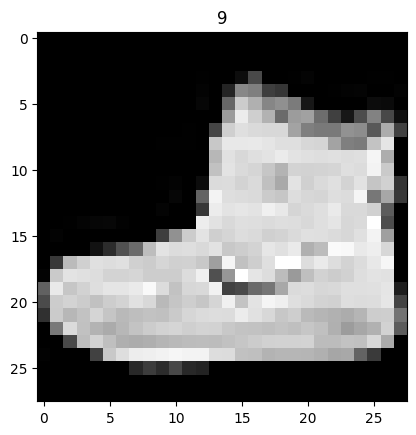

In [3]:
plt.title(train_labels_np[0])
plt.imshow(train_images_np[0], cmap='gray')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

train_images_np, valid_images_np, train_labels_np, valid_labels_np = train_test_split(
    train_images_np, train_labels_np, test_size=0.1, random_state=42, stratify=train_labels_np
)

np.bincount(train_labels_np), np.bincount(valid_labels_np)

(array([5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400]),
 array([600, 600, 600, 600, 600, 600, 600, 600, 600, 600]))

In [5]:
class FashionDataset(Dataset):
    def __init__(self, images_np, labels_np=None, transform=None):
        self.images_np = images_np
        self.labels_np = labels_np
        self.transform = transform

    def __len__(self):
        return len(self.images_np)

    def __getitem__(self, idx):
        img = self.images_np[idx]
        if self.transform is not None:
            img = self.transform(image=img)['image']
        if self.labels_np is None:
            return img
        label = self.labels_np[idx]
        return img, label

In [6]:
transform_train = A.Compose([
    A.Rotate(limit=(-15, 15)),
    A.GaussNoise(p=0.75),
    A.HorizontalFlip(p=0.5),

    A.ToFloat(max_value=255.0),
    A.pytorch.ToTensorV2()
])

transform_infer = A.Compose([
    A.ToFloat(max_value=255.0),
    A.pytorch.ToTensorV2()
])

train_ds = FashionDataset(train_images_np, train_labels_np, transform_train)
valid_ds = FashionDataset(valid_images_np, valid_labels_np, transform_infer)
test1_ds = FashionDataset(test1_images_np, transform=transform_infer)
test2_ds = FashionDataset(test2_images_np, transform=transform_infer)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False)
test1_loader = DataLoader(test1_ds, batch_size=64, shuffle=False)
test2_loader = DataLoader(test2_ds, batch_size=64, shuffle=False)

len(train_loader), len(valid_loader), len(test1_loader), len(test2_loader)

(844, 94, 79, 79)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2), # [16, 14, 14]
    
    nn.Conv2d(16, 32, kernel_size=5, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(), # [32, 14, 14]

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2), # [64, 7, 7]

    nn.Flatten(),
    nn.Linear(64*7*7, 512),
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)

model = model.to(device)

epochs, log_rate = 20, 2

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [9]:
def train_one_epoch(model, criterion, optimizer, train_loader):
    model.train()
    i, rloss, correct, total = 0, 0, 0, 0
    for X, y in (pbar := tqdm(train_loader, desc='Train Loader', leave=False)):
        X, y = X.to(device), y.to(device)
        output = model(X)
        preds = torch.argmax(output, dim=1)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        rloss += loss.item()
        correct += (preds==y).sum().item()
        total += len(y)
        pbar.set_postfix({'loss': f'{rloss/i:.5f}', 'acc': f'{correct/total:.5f}'})

    return rloss / i, correct / total

def valid_one_epoch(model, criterion, valid_loader):
    model.eval()
    i, rloss, correct, total = 0, 0, 0, 0
    for X, y in (pbar := tqdm(valid_loader, desc='Valid Loader', leave=False)):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            output = model(X)
            preds = torch.argmax(output, dim=1)
            loss = criterion(output, y)

        i += 1
        rloss += loss.item()
        correct += (preds==y).sum().item()
        total += len(y)
        pbar.set_postfix({'loss': f'{rloss/i:.5f}', 'acc': f'{correct/total:.5f}'})

    return rloss / i, correct / total

def train_loop(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, log_rate):
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    for epoch in tqdm(range(epochs), desc='Epoch'):
        tloss, tacc = train_one_epoch(model, criterion, optimizer, train_loader)
        
        if (epoch+1)%log_rate==0:
            print(f'Epoch: {epoch+1}/{epochs} | lr: {scheduler.get_lr()[0]:.5f}')
            print(f'Train Loss: {tloss:.5f} | Train Acc: {tacc:.5f}')
            
        vloss, vacc = valid_one_epoch(model, criterion, valid_loader)
        
        if (epoch+1)%log_rate==0:
            print(f'Valid Loss: {vloss:.5f} | Valid Acc: {vacc:.5f}')

        history['train_loss'].append(tloss)
        history['train_acc'].append(tacc)
        history['valid_loss'].append(vloss)
        history['valid_acc'].append(vacc)
        scheduler.step()
    return history

In [10]:
history = train_loop(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, log_rate)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 2/20 | lr: 0.00020
Train Loss: 0.54691 | Train Acc: 0.79793


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.39401 | Valid Acc: 0.86317


Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 4/20 | lr: 0.00018
Train Loss: 0.48257 | Train Acc: 0.81948


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.35167 | Valid Acc: 0.87317


Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 6/20 | lr: 0.00016
Train Loss: 0.45450 | Train Acc: 0.82978


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.34741 | Valid Acc: 0.87417


Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 8/20 | lr: 0.00013
Train Loss: 0.43290 | Train Acc: 0.83719


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.31981 | Valid Acc: 0.88183


Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 10/20 | lr: 0.00010
Train Loss: 0.41696 | Train Acc: 0.84185


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.29862 | Valid Acc: 0.89250


Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 12/20 | lr: 0.00007
Train Loss: 0.39952 | Train Acc: 0.85065


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.28234 | Valid Acc: 0.89600


Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 14/20 | lr: 0.00004
Train Loss: 0.38607 | Train Acc: 0.85559


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.27479 | Valid Acc: 0.90150


Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 16/20 | lr: 0.00002
Train Loss: 0.37928 | Train Acc: 0.85843


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.27037 | Valid Acc: 0.90467


Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 18/20 | lr: 0.00001
Train Loss: 0.37208 | Train Acc: 0.86104


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.26746 | Valid Acc: 0.90300


Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch: 20/20 | lr: 0.00000
Train Loss: 0.36975 | Train Acc: 0.86085


Valid Loader:   0%|          | 0/94 [00:00<?, ?it/s]

Valid Loss: 0.26398 | Valid Acc: 0.90383


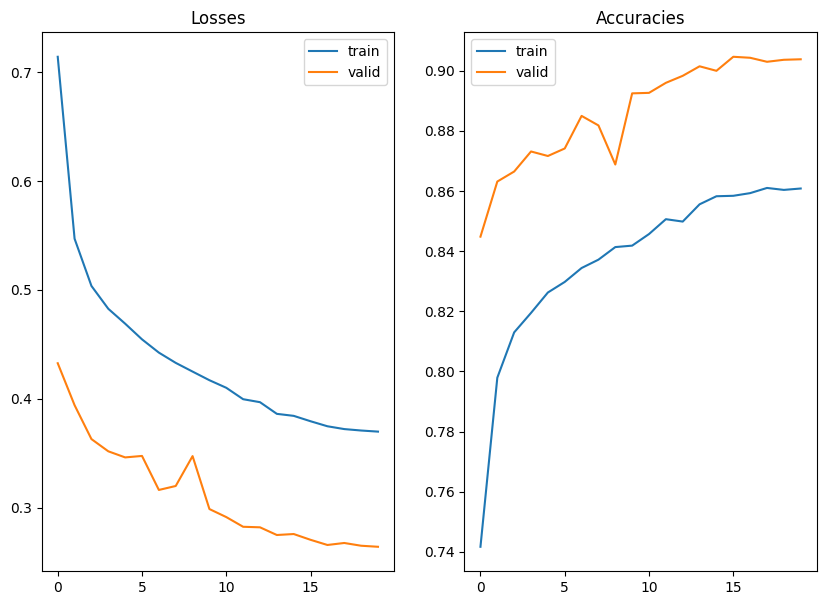

In [11]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history['train_loss'], label='train')
plt.plot(range(epochs), history['valid_loss'], label='valid')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history['train_acc'], label='train')
plt.plot(range(epochs), history['valid_acc'], label='valid')
plt.title('Accuracies')
plt.legend()

plt.show()

In [12]:
def infer(model, test_loader):
    model.eval()
    all_preds = []
    for X in tqdm(test_loader, desc='Test Loader'):
        X = X.to(device)
        with torch.no_grad():
            output = model(X)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().tolist())
    return np.array(all_preds)
        

In [13]:
y_pred1 = infer(model, test1_loader)
y_pred2 = infer(model, test2_loader)

Test Loader:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loader:   0%|          | 0/79 [00:00<?, ?it/s]

In [14]:
subm = pd.read_csv("/kaggle/input/fashion-classifier/sample_submission.csv")
subm['Category'] = np.concat([y_pred1, y_pred2])

subm.to_csv("submission.csv", index=False)
subm.head()

,Id,Category
0,0,6
1,1,3
2,2,6
3,3,5
4,4,2


In [15]:
subm['Category'].value_counts()

Category
4    1044
0    1028
2    1021
7    1019
8    1003
3     997
5     997
9     993
1     990
6     908
Name: count, dtype: int64